In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.rcParams['figure.dpi'] = 150
import seaborn as sns
import scipy.stats as st
import statsmodels
import statsmodels.api as sm
from functools import reduce

import glob, os, yaml, subprocess, itertools, sparse, sys, statsmodels
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

eigenvec_df = pd.read_csv("../PCA/eigenvec_100PC.csv", index_col=[0])
who_variants_combined = pd.read_csv("who_confidence_2021.csv")
analysis_dir = '/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue'

lineages = pd.read_csv("../data/combined_lineages_samples.csv", low_memory=False).query("Sample_ID in @eigenvec_df.index")
print(lineages.shape)
import collections, warnings
warnings.filterwarnings("ignore")

sys.path.append(os.path.join(os.path.dirname(os.getcwd()), "utils"))
from stats_utils import *

coll2014 = pd.read_csv("../data/coll2014_SNP_scheme.tsv", sep="\t")
coll2014["#lineage"] = coll2014["#lineage"].str.replace("lineage", "")
coll2014.rename(columns={"#lineage": "Lineage"}, inplace=True)

drug_abbr_dict = {"Delamanid": "DLM",
                  "Bedaquiline": "BDQ",
                  "Clofazimine": "CFZ",
                  "Ethionamide": "ETH",
                  "Linezolid": "LZD",
                  "Moxifloxacin": "MXF",
                  "Capreomycin": "CAP",
                  "Amikacin": "AMI",
                  "Pretomanid": "PTM",
                  "Pyrazinamide": "PZA",
                  "Kanamycin": "KAN",
                  "Levofloxacin": "LEV",
                  "Streptomycin": "STM",
                  "Ethambutol": "EMB",
                  "Isoniazid": "INH",
                  "Rifampicin": "RIF"
                 }

solo_results = pd.read_csv("../results/SOLO_Final_Aug2023.csv", header=[1]).query("tier==1")
drugs_lst = os.listdir(analysis_dir)

(49113, 7)


# Number of Samples in Each Drug Model (after dropping)

In [41]:
samples_summary_phenos = pd.DataFrame(columns=['Drug', 'Pheno', 'Unpooled', 'Pooled'])
i = 0

for drug in np.sort(drugs_lst):

    for pheno in os.listdir(os.path.join(analysis_dir, drug, 'BINARY', 'tiers=1')):

        unpooled_count = 0
        pooled_count = 0
    
        for model_path in glob.glob(os.path.join(analysis_dir, drug, 'BINARY', 'tiers=1', pheno, '*')):
            
            if os.path.isdir(model_path) and 'withSyn' not in model_path and os.path.isfile(os.path.join(model_path, 'model_matrix.pkl')):
                model_matrix = pd.read_pickle(os.path.join(model_path, 'model_matrix.pkl'))

                if 'unpooled' in model_path:
                    unpooled_count = len(model_matrix)
                elif 'poolSeparate' in model_path:
                    pooled_count = len(model_matrix)
                
        samples_summary_phenos.loc[i, :] = [drug, pheno.replace("phenos=", ""), unpooled_count, pooled_count]
        i += 1

In [45]:
actual_summary = samples_summary_phenos.pivot(index='Drug', columns=['Pheno'])
actual_summary = actual_summary[[('Unpooled', 'WHO'), (  'Pooled', 'WHO'), ('Unpooled', 'ALL'), (  'Pooled', 'ALL')]]
actual_summary.to_csv("../data/samples_counts_models.csv")
actual_summary

,Unpooled,Pooled,Unpooled,Pooled
Pheno,WHO,WHO,ALL,ALL
Drug,,,,
Amikacin,8454,8454,23614,23615
Bedaquiline,2012,2012,13861,13863
Capreomycin,9534,9534,16956,16956
Clofazimine,4916,4920,14690,14699
Delamanid,571,573,11594,11741
Ethambutol,32267,32267,44180,44180
Ethionamide,5890,5892,20444,20456
Isoniazid,34585,34587,48246,48251


In [ ]:
2012, 13863

In [51]:
np.sort(actual_summary.values.flatten())

array([0, 0, 0, 571, 573, 688, 688, 2012, 2012, 4916, 4920, 5890, 5892,
       5901, 7553, 7554, 8295, 8295, 8454, 8454, 9534, 9534, 11594, 11741,
       12200, 12200, 13861, 13863, 14690, 14699, 16065, 16065, 16956,
       16956, 18151, 18237, 19714, 19715, 20444, 20456, 21097, 21099,
       22402, 22402, 23494, 23496, 23614, 23615, 24298, 24312, 27108,
       27108, 32267, 32267, 34585, 34587, 35068, 35068, 44180, 44180,
       47241, 47241, 48246, 48251], dtype=object)

# Bedaquiline Skew between WHO and ALL Datasets

In [11]:
drug = "Bedaquiline"
assert len(glob.glob(f"/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue-raw-data/phenotypes/drug_name={drug}/*")) == 1
df_phenos = pd.read_csv(glob.glob(f"/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue-raw-data/phenotypes/drug_name={drug}/*")[0])
df_phenos_processed = pd.read_csv(os.path.join(analysis_dir, drug, "phenos_binary.csv"))

df_phenos_processed = df_phenos_processed.merge(lineages, left_on='sample_id', right_on='Sample_ID', how='left')
print(len(df_phenos_processed.loc[pd.isnull(df_phenos_processed['Lineage'])]), len(df_phenos_processed))

df_WHO = df_phenos_processed.query("phenotypic_category=='WHO'")
df_ALL = df_phenos_processed.copy()
print(len(df_WHO), len(df_ALL))

7 14135
2165 14135


In [12]:
df_phenos.query("phenotypic_category in ['WHO', 'ALL']").box.value_counts()

box
CRyPTIC_MIC      11231
WHO_current       2076
non_WHO_CC_S       676
WHO_past            89
WHO_undefined       34
non_WHO_CC_R        29
Name: count, dtype: int64

In [13]:
df_phenos.query("phenotypic_category=='WHO'").sample_id.nunique(), df_phenos.query("phenotypic_category in ['WHO', 'ALL']").sample_id.nunique()

(2165, 14135)

In [ ]:
results_

In [14]:
df_WHO_lineage = pd.DataFrame(df_WHO.Lineage.value_counts()).reset_index()
df_WHO_lineage['Proportion'] = df_WHO_lineage['count'] / df_WHO_lineage['count'].sum()
df_WHO_lineage.loc[-1, :] = ['Total', df_WHO_lineage['count'].sum(), 1]
df_WHO_lineage['Dataset'] = 'WHO'

df_ALL_lineage = pd.DataFrame(df_ALL.Lineage.value_counts()).reset_index()
df_ALL_lineage['Proportion'] = df_ALL_lineage['count'] / df_ALL_lineage['count'].sum()
df_ALL_lineage.loc[-1, :] = ['Total', df_ALL_lineage['count'].sum(), 1]
df_ALL_lineage['Dataset'] = 'ALL'

lineages_combined = pd.concat([df_WHO_lineage, df_ALL_lineage])

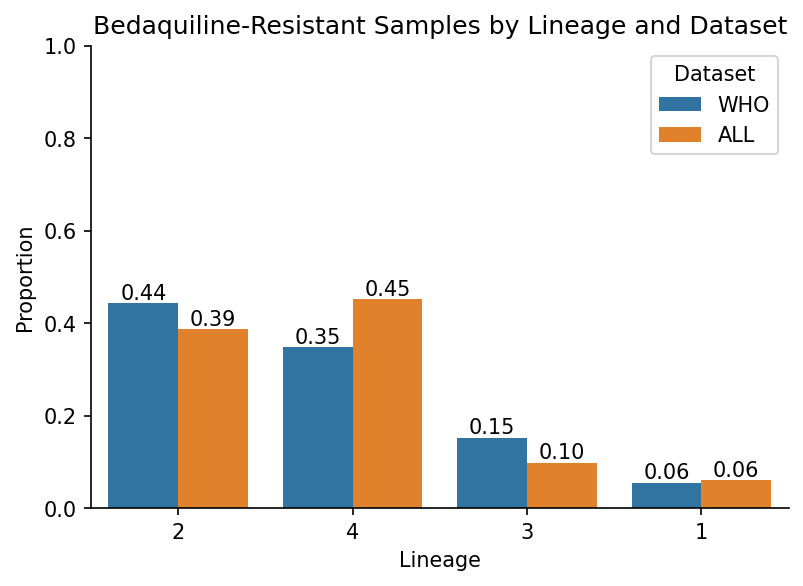

In [16]:
fig, ax = plt.subplots(figsize=(6, 4))

sns.barplot(data=lineages_combined.query("Proportion > 0.005 & Proportion < 1"),
            x='Lineage',
            y='Proportion',
            hue='Dataset',
            ax=ax
           )

for container in ax.containers:
    ax.bar_label(container, fmt='{:.2f}')

plt.ylabel("Proportion")
plt.title(f"{drug}-Resistant Samples by Lineage and Dataset")
plt.ylim(0, 1)
sns.despine()
plt.show()

In [110]:
BDQ_MIC_results = pd.read_csv("/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue/Bedaquiline/MIC/tiers=1/dropAF_noSyn_unpooled/model_analysis.csv")
BDQ_results = pd.read_csv("../results/FINAL/Bedaquiline.csv")
BDQ_results.shape, BDQ_MIC_results.shape

((831, 55), (609, 9))

In [108]:
BDQ_results.query("mutation=='mmpS5_c.-74G>T'")[['mutation', 'WHO_Odds_Ratio', 'WHO_BH_pval', 'WHO_BH_LRT_pval', 'WHO_Present_R', 'WHO_Present_S', 'WHO_Absent_R', 'WHO_Absent_S', 'WHO_PPV_LB', 'WHO_PPV']]

,mutation,WHO_Odds_Ratio,WHO_BH_pval,WHO_BH_LRT_pval,WHO_Present_R,WHO_Present_S,WHO_Absent_R,WHO_Absent_S,WHO_PPV_LB,WHO_PPV
4,mmpS5_c.-74G>T,1.40935,0.0,8.151491e-13,32.0,3.0,732.0,1245.0,0.769425,0.914286


In [109]:
BDQ_results.query("mutation=='mmpS5_c.-74G>T'")[['mutation', 'ALL_Odds_Ratio', 'ALL_BH_pval', 'ALL_BH_LRT_pval', 'ALL_Present_R', 'ALL_Present_S', 'ALL_Absent_R', 'ALL_Absent_S', 'ALL_PPV_LB', 'ALL_PPV']]

,mutation,ALL_Odds_Ratio,ALL_BH_pval,ALL_BH_LRT_pval,ALL_Present_R,ALL_Present_S,ALL_Absent_R,ALL_Absent_S,ALL_PPV_LB,ALL_PPV
4,mmpS5_c.-74G>T,1.219286,0.0,1.924069e-37,32.0,89.0,848.0,12892.0,0.188448,0.264463


In [112]:
BDQ_MIC_results.query("mutation=='mmpS5_c.-74G>T'")

,mutation,coef,pval,neutral_pval,BH_pval,Bonferroni_pval,BH_neutral_pval,Bonferroni_neutral_pval,confidence
379,mmpS5_c.-74G>T,-0.003734,0.424,0.167,0.4872,1.0,1.0,1.0,3) Uncertain significance


In [100]:
BDQ_results.loc[(BDQ_results['Initial confidence grading WHO dataset'] != BDQ_results['Initial confidence grading ALL dataset'])][['mutation', 'Initial confidence grading WHO dataset', 'Initial confidence grading ALL dataset']]

,mutation,Initial confidence grading WHO dataset,Initial confidence grading ALL dataset
4,mmpS5_c.-74G>T,Assoc w R,Uncertain
9,Rv0678_p.Met146Thr,Assoc w R,Uncertain
16,mmpL5_c.2889G>A,Possible Assoc w R,Uncertain
26,atpE_p.Ala63Pro,Uncertain,Assoc w R
27,Rv0678_p.Cys46Arg,Possible Assoc w R,Assoc w R
...,...,...,...
826,mmpL5_p.Ile555_Gly559del,NaN,NaN
827,mmpS5_c.-9_-8delCG,NaN,NaN
828,pepQ_c.21A>C,NaN,NaN
829,Rv0678_p.Arg109fs,NaN,NaN


In [73]:
df_WHO_lineage_phenos = pd.DataFrame(df_WHO.groupby("Lineage").phenotype.mean()).reset_index()
df_WHO_lineage_phenos.loc[-1, :] = ['Total', df_WHO.loc[~pd.isnull(df_WHO['Lineage'])].phenotype.mean()]
df_WHO_lineage_phenos['Dataset'] = 'WHO'

df_ALL_lineage_phenos = pd.DataFrame(df_ALL.groupby("Lineage").phenotype.mean()).reset_index()
df_ALL_lineage_phenos.loc[-1, :] = ['Total', df_ALL.loc[~pd.isnull(df_ALL['Lineage'])].phenotype.mean()]
df_ALL_lineage_phenos['Dataset'] = 'ALL'

lineage_phenos_combined = pd.concat([df_WHO_lineage_phenos, df_ALL_lineage_phenos])
print(len(set(df_WHO.sample_id).intersection(df_ALL.sample_id)))

2165


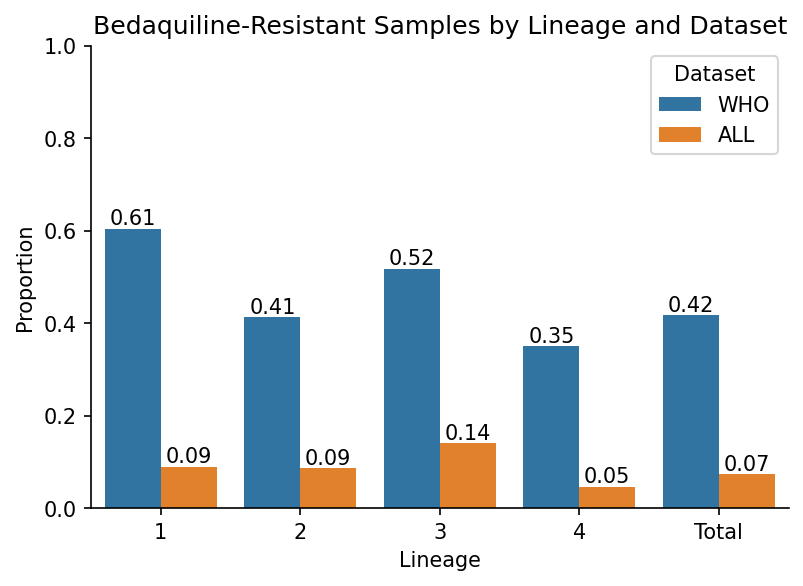

In [91]:
fig, ax = plt.subplots(figsize=(6, 4))

sns.barplot(data=lineage_phenos_combined.query("phenotype > 0.005"),
            x='Lineage',
            y='phenotype',
            hue='Dataset',
            ax=ax
           )

for container in ax.containers:
    ax.bar_label(container, fmt='{:.2f}')

plt.ylabel("Proportion")
plt.title("Bedaquiline-Resistant Samples by Lineage and Dataset")
plt.ylim(0, 1)
sns.despine()
plt.savefig("../figures/BDQ_phenos_by_lineage_dataset.png", dpi=300)

# Lineage Distribution for Each Drug Model

In [52]:
def create_lineage_summary_df(og_lineages_df, other_thresh=0.01):
    '''
    other_cols is a list of lineages that should be combined into an other category because there are so few of them. Basically just for aesthetic purposes
    '''
    
    lineage_summary = pd.DataFrame(og_lineages_df["Lineage"].value_counts())

    lineage_summary = lineage_summary.reset_index().rename(columns={"index":"Lineage", "Lineage": "Count"})
    
    # get lineages that are present at < 1% frequency. Combine them into an "Other" category for aesthetic purposes in plotting
    samples_total = lineage_summary["Count"].sum()
    samples_thresh = int(other_thresh*samples_total)
    other_cols = lineage_summary.query("Count < @samples_thresh")["Lineage"].values
    
    # ",".join(other_cols) --> this makes the name too long, but can try later
    # combine low-frequency lineages into an Other category
    lineage_summary = pd.concat([lineage_summary, 
                                 pd.DataFrame({"Lineage": "Other", "Count": lineage_summary.query("Lineage in @other_cols")["Count"].sum()
                                              }, index=[-1])
                                ]).query("Lineage not in @other_cols")
    
    lineage_summary = lineage_summary.sort_values("Lineage", ascending=True).reset_index(drop=True)
    lineage_summary["Count"] = lineage_summary["Count"].astype(int)
    return lineage_summary

In [53]:
single_lineages = lineages.query("~Coll2014.str.contains(',')")

# percent mixed lineage samples
print((len(lineages)-len(single_lineages)) / len(lineages))

# add primary lineage column
for i, row in single_lineages.iterrows():
    if row["Coll2014"][0].isnumeric():
        single_lineages.loc[i, "Lineage"] = row["Coll2014"][0]
    else:
        single_lineages.loc[i, "Lineage"] = row["Coll2014"]

0.010669272901268503


In [54]:
create_lineage_summary_df(single_lineages)

TypeError: can't multiply sequence by non-int of type 'float'